In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
sys.path.append('..')
sys.path.append('../visualization')
import acd
import viz_1d as viz
device = 'cpu'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# form class to hold data
class B:
    text = torch.zeros(1).to(device)

sys.path.append('../dsets/sst')
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment
sst_pkl = pickle.load(open('../dsets/sst/sst_vocab.pkl', 'rb'))

# load model

In [ ]:
model = torch.load('../dsets/sst/sst.model', map_location=device)
model.device = device

# run examples

/accounts/projects/vision/chandan/hierarchical-dnn-interpretations/acd/agglomeration/agg_1d.py:28: RuntimeWarning: invalid value encountered in greater_equal
  mask = scores >= thresh
/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


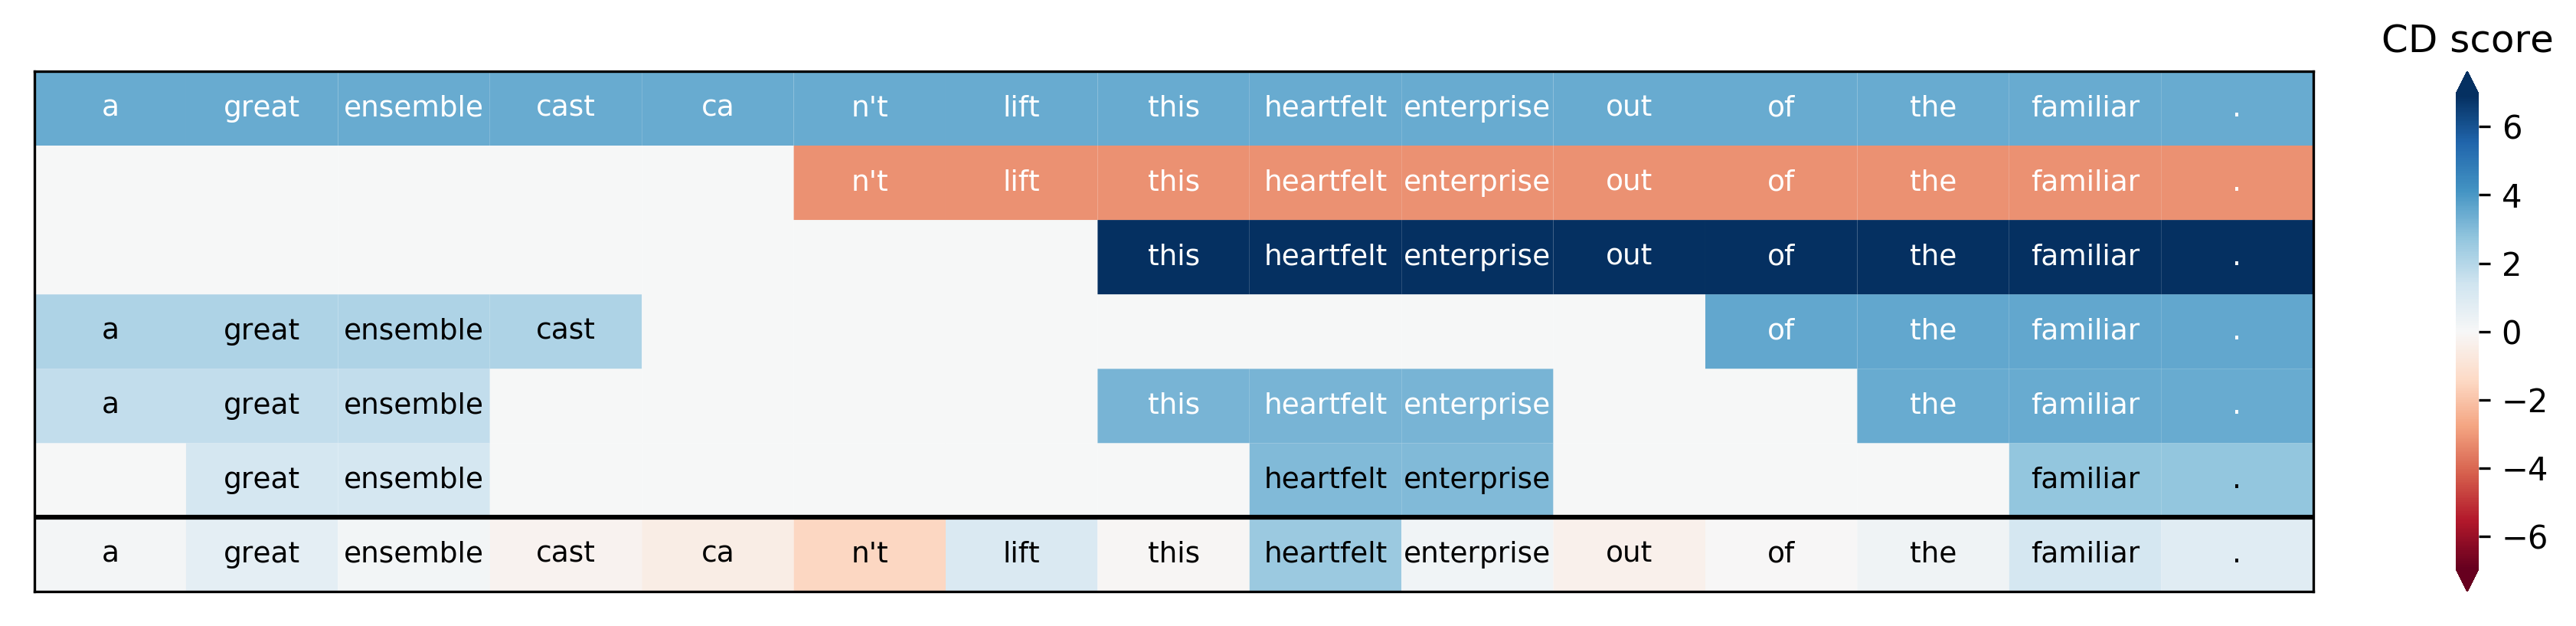

In [3]:
# base parameters
sweep_dim = 1 # how large chunks of text should be considered (1 for words)
method = 'cd' # build_up, break_down, cd
percentile_include = 99.5 # keep this very high so we don't add too many words at once
num_iters = 25 # maximum number of iterations (rarely reached)

# text and label
sentence = ['a', 'great', 'ensemble', 'cast', 'ca', 'n\'t', 'lift', 'this', 'heartfelt', 'enterprise', 'out', 'of', 'the', 'familiar', '.'] # note this is a real example from the dataset
# sentence = ['not', 'good', ',', 'not', 'bad', ',', 'just', 'okay'] # any text with words from this dataset can be interpreted
label = 1 # 0 if positive 1 if negative


def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'][x] for x in s]).transpose(), axis=1)
    batch.text = torch.LongTensor(nums).to(device) #cuda()
    return batch

# prepare inputs
batch = batch_from_str_list(sentence)
scores_all = model(batch).data.cpu().numpy()[0] # predict
label_pred = np.argmax(scores_all) # get predicted class

# agglomerate
lists = acd.agg_1d.agglomerate(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                    label_pred, num_iters=num_iters, device=device) # see agg_1d.agglomerate to understand what this dictionary contains
lists = acd.agg_1d.collapse_tree(lists) # don't show redundant joins

# visualize
viz.word_heatmap(sentence, lists, label_pred, label, fontsize=9)